# Определение возраста покупателей

##  Описание данных
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

В нашем распоряжении набор фотографий людей с указанием возраста. Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.

В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

**Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.**

## Исследовательский анализ данных

- Посмотрим на размер выборки.
- Построим график распределения возраста в выборке.
- Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.
- Сделаем выводы о том, как результаты исследования повлияют на обучение модели.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# посмотрим на наличие дублей
data['file_name'].duplicated().sum()

0

In [6]:
# посмотрим на наличие пропусков
data.isna().sum()

file_name    0
real_age     0
dtype: int64

<AxesSubplot:title={'center':'Распределение возрастов'}, xlabel='Возраст', ylabel='Количество'>

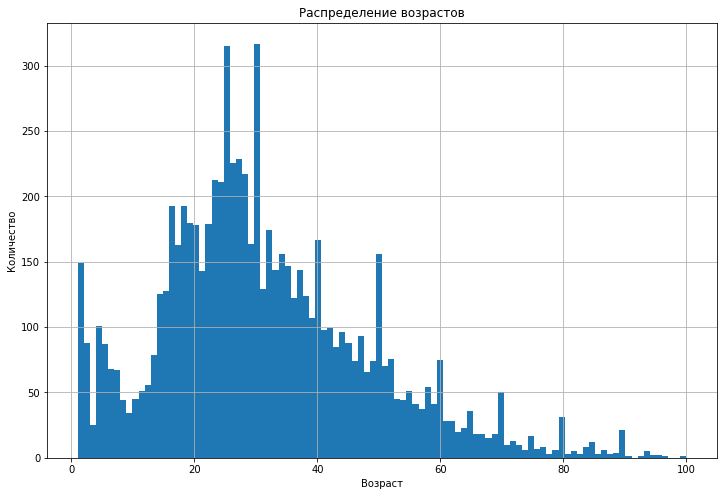

In [14]:
# Посмотрим на респределение количества человек по возрастам
plt.figure(figsize=(12,8))
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество')
data['real_age'].hist(bins=100)

In [8]:
# Сформируем из набора данных и файлов изображений батчи с изображениями и метками классов
datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [9]:
# получим объект, у которого пары «картинки — метки»
features, target = next(train_datagen_flow)

In [10]:
# посмотрим на четырёхмерный тензор первого батча
features.shape

(16, 224, 224, 3)

In [11]:
# выведем метки возростов в первом батче
target

array([50, 41, 46, 85, 14, 40, 14, 53,  4, 32, 14, 23, 37, 62, 21, 58])

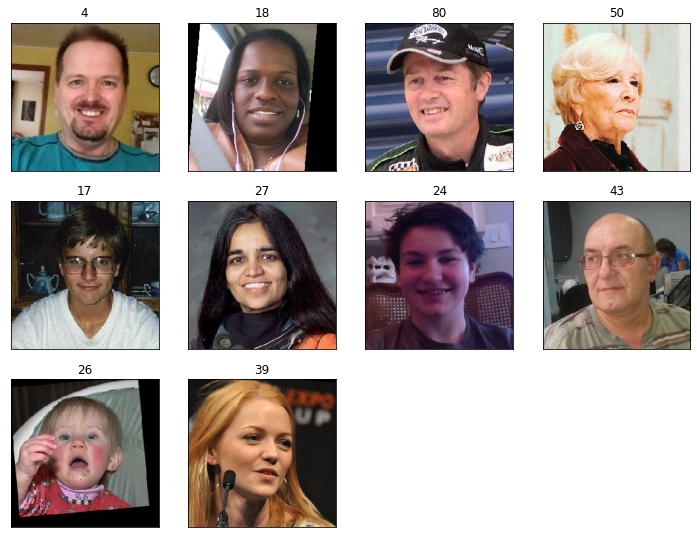

In [17]:
# Выведем 10 изображений с указанием возрастов
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(data.iloc[i]['real_age'])
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**ВЫВОДЫ:** В данных 7591 изображений и файл с именами соответствующих изображений и возрастом человека (метками). В файле с метками отсутствуют дубликаты и пропуски. Распределение изображений по возрастам неоднородно, имеются всплески, также большая часть приходится на возраст от 15 до 50 лет (дисбаланс в признаках не очень хорошо влияет на обучение). Возраст людей на фото соответствует изображениею.

## Обучение модели

**Число в ответе — это количество лет. Прогноз и верный ответ можно сравнить: чем дальше предсказание от реального ответа, тем оно хуже. Нам предстоит решать задачу регрессии.**

**Будем использовать готовую архитектуру сверточной нейронной сети ResNet50 с активацией ReLU, т.к. положительные прогнозы сети функция ReLU не меняет, а все отрицательные — приводит к нулю, а у нас возростов меньше 0 быть не может. В выходном слое нужен всего один нейрон, который вернёт число-предсказание.**

**В качестве фунции потерь будем использовать MSE, а оценивать качество модели будем при помощи MAE, значение которой не должно быть больше 7.**

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345,
        subset='training')
    return train_datagen_flow

def load_test(path):
    data = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=16,
        seed=12345,
        shuffle=True,
        subset='validation')
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=12, steps_per_epoch=None, validation_steps=None):
    
    model.fit(
        train_data, 
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.


```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

 Train for 356 steps, validate for 119 steps
Epoch 1/12

356/356 - 53s - loss: 203.9710 - mae: 10.8317 - val_loss: 470.1989 - val_mae: 16.6051
Epoch 2/12

356/356 - 43s - loss: 132.4891 - mae: 8.7694 - val_loss: 229.2252 - val_mae: 11.8011
Epoch 3/12

356/356 - 43s - loss: 109.2851 - mae: 7.9308 - val_loss: 116.6765 - val_mae: 8.1786
Epoch 4/12

356/356 - 44s - loss: 91.9032 - mae: 7.3069 - val_loss: 134.6465 - val_mae: 8.5221
Epoch 5/12

356/356 - 59s - loss: 81.5124 - mae: 6.9369 - val_loss: 152.3777 - val_mae: 9.8116
Epoch 6/12

356/356 - 67s - loss: 66.7915 - mae: 6.2974 - val_loss: 105.9686 - val_mae: 7.9835
Epoch 7/12

356/356 - 72s - loss: 55.6980 - mae: 5.7110 - val_loss: 95.7231 - val_mae: 7.3797
Epoch 8/12

356/356 - 72s - loss: 47.5658 - mae: 5.2687 - val_loss: 101.9830 - val_mae: 7.6706
Epoch 9/12

356/356 - 73s - loss: 39.7564 - mae: 4.8603 - val_loss: 87.8498 - val_mae: 7.2284
Epoch 10/12

356/356 - 47s - loss: 36.7734 - mae: 4.6664 - val_loss: 103.4316 - val_mae: 7.9637
Epoch 11/12

356/356 - 44s - loss: 30.3049 - mae: 4.2232 - val_loss: 94.1350 - val_mae: 7.2279
Epoch 12/12

356/356 - 43s - loss: 27.1790 - mae: 4.0381 - val_loss: 89.6217 - val_mae: 7.2010
WARNING:tensorflow:sample_weight modes were coerced from

  ...
    to  
  ['...']
119/119 - 10s - loss: 89.6217 - mae: 7.2010

## Анализ обученной модели

**ОБЩИЙ ВЫВОД:**
Мы провели исследовательский анализ набора фотографий с метками возрастов. Присутствует дисбаланс по возрастам, что будет влиять на качество модели. Все изображения находились в одном каталоге, а их соответствующие классы в файле CSV, после обработки мы получили объекты, у которых пары «картинки — метки». Мы подготовили эти данные к обучению. Для этого мы на вход передали изображения в диапазоне от 0 до 1 (поделив массив на 255), также для обучающей выборки мы использовали горизонтальную аугментацию. 

Мы создали модель для работы системы компьютерного зрения для обработки фотографий покупателей, которая поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
 
При работе с изображениями качество сети улучшается, если добавить к ней свёрточные слои, но в свёрточных нейросетях при количестве слоев более 20 происходит затухание градиента. Поэтому мы использовали более сложную архитектуру свёрточных нейросетей ResNet50 с 50 слоями. Для ускорения обучения модели мы применили алгоритм Adam, чтобы подбор шага был автоматическим. 

Метрика MAE составила 7,2  

